In [1]:
from data_prep.data_prep import prepare_all_data
from training.training import prepare_model_data, grid_search
from training.feature_selection import forward_feature_selection, correlation_feature_selection,projection_predictive_selection
from model import burglary_model
from utils.utils import single_out_last, setup_reproducibility
from testing.testing import StatisticalTester
from pipeline import train_and_evaluate_model, cross_validate_time_splits
model_tuple, occupation_mappings,ward_idx_map = prepare_all_data("../merged_data.parquet", "lsoa")

c:\Users\rayan\anaconda3\envs\fdc2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = setup_reproducibility(42)
print(f'Using device: {device}')
training_data, testing_data = single_out_last(model_tuple[0])

Using device: cpu


In [3]:
# #Automated Feature Selection Block 
# #Correlation Feature Selection: Computationally Light
# #FORWARD Feature Selection: Computationally Heavy, More Accurate but needs a GPU
# inner_train,inner_val = single_out_last(training_data)
# candidate_features = {
#     "static": model_tuple[1],
#     'dynamic': model_tuple[2],
#     'seasonal': model_tuple[3],
#     'time_trend': model_tuple[4],
#     'temporal': model_tuple[5],
#     'spatial': model_tuple[6],
#     }
# #selected_feats = correlation_feature_selection(inner_train,candidate_features, max_features=12,print_progress=True)
# selected_feats=projection_predictive_selection(
#     burglary_model,
#     inner_train,
#     inner_val,
#     candidate_features,
#     device,
#     num_steps=200,
#     lr=1e-3,
#     guide_type='diag',
#     verbose=False,
#     max_features=10,
#     print_progress=True
# )
# print(f"Selected features: {selected_feats}")
# #Forward Feature Selection:
# #selected_feats = forward_feature_selection(burglary_model,inner_train,inner_val,candidate_features,device,num_steps=200,lr=1e-3,guide_type='diag',verbose=False max_features=10, print_progress=True)
# ['Car or van availability|1 car or van in household (%)', 'Car or van availability|Cars per household', 'Car or van availability|No cars or vans in household (%)', 'Ethnic Group|BAME (%)', 'Household Composition|% Other multi person household', 'Household Composition|% Couple household with dependent children', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|6a', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|2', 'Tenure|Owned outright (%)', 'n_neighbors', 'Public Transport Accessibility Levels|% 4-6 (good access)|Level3_67', 'Tenure|Owned with a mortgage or loan (%)', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|1b', 'Dwelling type|Flat, maisonette or apartment (%)', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|4', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|5', 'Household Composition|% One person household', 'Ethnic Group|Asian/Asian British (%)', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|3', 'Shopping locations', 'Ethnic Group|Black/African/Caribbean/Black British (%)', 'Ethnic Group|Other ethnic group (%)', 'area', 'Public transport locations', 'Public Transport Accessibility Levels|% 2-3 (average access)|Level3_66', 'Ethnic Group|White (%)', 'Education locations', 'Car or van availability|4 or more cars or vans in household (%)', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|1a', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|6b', 'Public Transport Accessibility Levels|% 0-1 (poor access)|Level3_65', 'Car or van availability|2 cars or vans in household (%)'],
# ['Barriers to Housing and Services Rank (where 1 is most deprived)', 'Mid-year Population Estimates|All Ages', 'Mid-year Population Estimates|Aged 45-64', 'Mid-year Population Estimates|Aged 0-15', 'lag_1_x_n_neighbors', 'Employment Rank (where 1 is most deprived)', 'Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)', 'Mid-year Population Estimates|Working-age', 'Health Deprivation and Disability Rank (where 1 is most deprived)', 'Mid-year Population Estimates|Aged 65+', 'Education, Skills and Training Rank (where 1 is most deprived)', 'Income Rank (where 1 is most deprived)'],
# ['during_corona', 'post_corona'],
# ['time_log'],
# ['lag_1', 'lag_3'],
# ['lag1_diff_neighbors', 'lag_1_x_n_neighbors', 'lag1_median_neighbors', 'lag1_mean_neighbors', 'lag1_sum_neighbors'],

# rmse          2.185602
# mae           1.073718
# crps          1.527997


# ['Ethnic Group|BAME (%)', 'Car or van availability|No cars or vans in household (%)', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|4', 'n_neighbors', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|3', 'Public Transport Accessibility Levels|% 0-1 (poor access)|Level3_65', 'Household Composition|% One person household', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|6a', 'Ethnic Group|Asian/Asian British (%)', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|2', 'Ethnic Group|Black/African/Caribbean/Black British (%)', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|6b', 'Car or van availability|1 car or van in household (%)', 'Ethnic Group|Other ethnic group (%)', 'Tenure|Owned with a mortgage or loan (%)', 'Car or van availability|2 cars or vans in household (%)'],
# ['Mid-year Population Estimates|All Ages', 'Mid-year Population Estimates|Aged 0-15', 'Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)', 'Education, Skills and Training Rank (where 1 is most deprived)', 'Mid-year Population Estimates|Aged 45-64', 'Employment Rank (where 1 is most deprived)', 'Income Rank (where 1 is most deprived)'],
# ["post_corona", "month_sin"],
# ['time_log'],
# ['lag_1'],
# ['lag1_diff_neighbors', 'lag1_mean_neighbors', 'lag_1_x_n_neighbors']

# rmse          1.595894
# mae           0.933347
# crps          0.702800



# ['Tenure|Owned with a mortgage or loan (%)', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|2', 'Car or van availability|No cars or vans in household (%)', 'Household Composition|% One person household', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|4', 'Ethnic Group|Black/African/Caribbean/Black British (%)'],
# ['Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)', 'Employment Rank (where 1 is most deprived)', 'Mid-year Population Estimates|Aged 0-15', 'Income Rank (where 1 is most deprived)'],
# ["during_corona", "month_sin"],
# ['time_log'],
# ['lag_1'],
# ['lag1_diff_neighbors', 'lag1_mean_neighbors']

# rmse          1.595894
# mae           0.933347
# crps          0.702800

#model_tuple = (
#    model_tuple[0],
#['Ethnic Group|BAME (%)', 'Car or van availability|No cars or vans in household (%)', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|4', 'n_neighbors', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|3', 'Public Transport Accessibility Levels|% 0-1 (poor access)|Level3_65', 'Household Composition|% One person household', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|6a', 'Ethnic Group|Asian/Asian British (%)', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|2', 'Ethnic Group|Black/African/Caribbean/Black British (%)', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|6b', 'Car or van availability|1 car or van in household (%)', 'Ethnic Group|Other ethnic group (%)', 'Tenure|Owned with a mortgage or loan (%)', 'Car or van availability|2 cars or vans in household (%)'],
#['Mid-year Population Estimates|All Ages', 'Mid-year Population Estimates|Aged 0-15', 'Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)', 'Education, Skills and Training Rank (where 1 is most deprived)', 'Mid-year Population Estimates|Aged 45-64', 'Employment Rank (where 1 is most deprived)', 'Income Rank (where 1 is most deprived)'],
#["post_corona", "month_sin"],
#['time_log'],
#['lag_1'],
#['lag1_diff_neighbors', 'lag1_mean_neighbors', 'lag_1_x_n_neighbors']
#)

gdf = model_tuple[0]
split_point = gdf['time_s'].max() - 3
train_df = gdf[gdf['time_s'] < split_point]
val_df = gdf[gdf['time_s'] >= split_point]

candidate_features = {
    'static': model_tuple[1],
    'dynamic': model_tuple[2],
    'seasonal': model_tuple[3],
    'time_trend': model_tuple[4],
    'temporal': model_tuple[5],
    'spatial': model_tuple[6],
}

selected_feats = forward_feature_selection(
    burglary_model,
    train_df,
    val_df,
    candidate_features,
    device,
    max_features=10,
    debug_random=False,
)

print('Selected features (debug mode):')
for group, feats in selected_feats.items():
    print(group, feats)

model_tuple = (
    model_tuple[0],
    selected_feats['static'],
    selected_feats['dynamic'],
    selected_feats['seasonal'],
    selected_feats['time_trend'],
    selected_feats['temporal'],
    selected_feats['spatial'],
)
print(model_tuple)


c:\Users\rayan\OneDrive\Documents\GitHub\ARWCASP\model\training\training.py:110: RuntimeWarning: invalid value encountered in divide
  X = (X - means) / stds
Training SVI: 100%|██████████| 500/500 [00:08<00:00, 59.63it/s] 
c:\Users\rayan\OneDrive\Documents\GitHub\ARWCASP\model\training\training.py:110: RuntimeWarning: divide by zero encountered in divide
  X = (X - means) / stds
c:\Users\rayan\OneDrive\Documents\GitHub\ARWCASP\model\training\training.py:110: RuntimeWarning: invalid value encountered in divide
  X = (X - means) / stds
c:\Users\rayan\OneDrive\Documents\GitHub\ARWCASP\model\training\training.py:110: RuntimeWarning: invalid value encountered in divide
  X = (X - means) / stds
Training SVI: 100%|██████████| 500/500 [00:04<00:00, 108.81it/s]
c:\Users\rayan\OneDrive\Documents\GitHub\ARWCASP\model\training\training.py:110: RuntimeWarning: divide by zero encountered in divide
  X = (X - means) / stds
c:\Users\rayan\OneDrive\Documents\GitHub\ARWCASP\model\training\training.py:11

KeyboardInterrupt: 

In [8]:
results = cross_validate_time_splits(model_tuple, "time_s", 12, burglary_model,
                           occupation_mappings[1], device, ward_idx_map)

Training SVI:  79%|███████▉  | 395/500 [00:08<00:02, 46.15it/s]


KeyboardInterrupt: 

In [5]:
results[0]

,train_time,test_time,rmse,mae,crps
0,-1.480323,1.500464,5.765928,1.615710,4.553515
1,-1.480323,1.520604,3.801971,1.250151,4.390444
2,-1.480323,1.540745,4.169085,1.059013,4.631397
3,-1.480323,1.560885,2.025219,1.291440,2.713237
4,-1.480323,1.581026,312.177216,6.517220,4.436736
5,-1.480323,1.601166,1.782030,0.989929,2.447714
6,-1.480323,1.621307,312.038422,5.505842,3.590910
7,-1.480323,1.641447,1.909516,1.078163,4.034856
8,-1.480323,1.661587,440.742706,10.826954,5.240769
9,-1.480323,1.681728,6.137476,2.434529,4.277503


In [6]:
results[0].mean()

train_time     -1.480323
test_time       1.611236
rmse          117.264977
mae             3.351418
crps            3.817559
dtype: float64

In [7]:
train_data = prepare_model_data(training_data, *model_tuple[1:], device, ward_idx_map=ward_idx_map)
test_data = prepare_model_data(testing_data, *model_tuple[1:], device, train_data["means"], train_data["stds"], ward_idx_map)

evaluation_metrics, svi, svi.guide, prediction_tester = train_and_evaluate_model(train_data, test_data, burglary_model, occupation_mappings[1])

Training SVI: 100%|██████████| 500/500 [00:11<00:00, 44.62it/s]


In [8]:
factors_map ={
    "b_static": model_tuple[1],
    "b_dynamic": model_tuple[2],
    "b_seasonal": model_tuple[3],
    "b_time_tr": model_tuple[4],
    "b_temporal": model_tuple[5],
    "b_spatial": model_tuple[6],
}


statistical_tester = StatisticalTester(test_data, burglary_model, svi.guide, factors_map)

In [9]:
statistical_tester.predict(5_000)

In [10]:
factor_summaries= statistical_tester.evaluate_all(alpha=0.1)

In [11]:
# import pandas as pd
# inner_train, inner_val = single_out_last(training_data)
# param_grid = {
#       "lr": [1e-2, 5e-3, 1e-3],
#       "guide_type": ["diag", "lowrank"]
#       }
# results_df = grid_search(
#       burglary_model,
#       inner_train,
#       inner_val,
#       *model_tuple[1:],
#       device,
#       param_grid,
#       ward_idx_map=ward_idx_map,
#       num_steps=500,
#       )
# print(results_df)
# print("Best parameters:", results_df.loc[0].to_dict())

In [12]:
for key, value in factor_summaries.items():
    print(value.query("significant_CI == 'Yes'")["col"].tolist())

['Household Composition|% Couple household without dependent children', 'Households|All households', 'Ethnic Group|White (%)', 'Dwelling type|Flat, maisonette or apartment (%)', 'Household Composition|% Lone parent household', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|1b', 'Food locations', 'Ethnic Group|BAME (%)', 'Car or van availability|1 car or van in household (%)', 'Tenure|Owned outright (%)', 'Household Composition|% Other multi person household', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|4', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|6b', 'shared_length', 'Public Transport Accessibility Levels|Number of people in each PTAL level:|6a', 'Ethnic Group|Mixed/multiple ethnic groups (%)', 'Parking locations', 'Car or van availability|3 cars or vans in household (%)', 'Tenure|Private rented (%)', 'Public Transport Accessibility Levels|Average Score|Level3_64', 'Public Transport Accessi

In [13]:
factor_summaries["b_spatial"]

,col,mean,ci_lower,ci_upper,p_val,significant_CI


In [14]:
factors_map ={
    "b_static": model_tuple[1],
    "b_dynamic": model_tuple[2],
    "b_seasonal": model_tuple[3],
    "b_time_tr": model_tuple[4],
    "b_temporal": model_tuple[5],
    "b_spatial": model_tuple[6],
}

In [15]:
check = prediction_tester.get_median_predictions()

In [16]:
check["true"] = prediction_tester.y
check["diff"] = check["median"] - check["true"]

In [17]:
check

,median,true,diff
E01000001,0.0,0,0.0
E01000002,0.0,0,0.0
E01000003,1.0,1,0.0
E01000005,1.0,1,0.0
E01000006,1.0,0,1.0
...,...,...,...
E01035688,0.0,4,-4.0
E01035689,0.0,0,0.0
E01035690,0.0,4,-4.0
E01035691,0.0,0,0.0


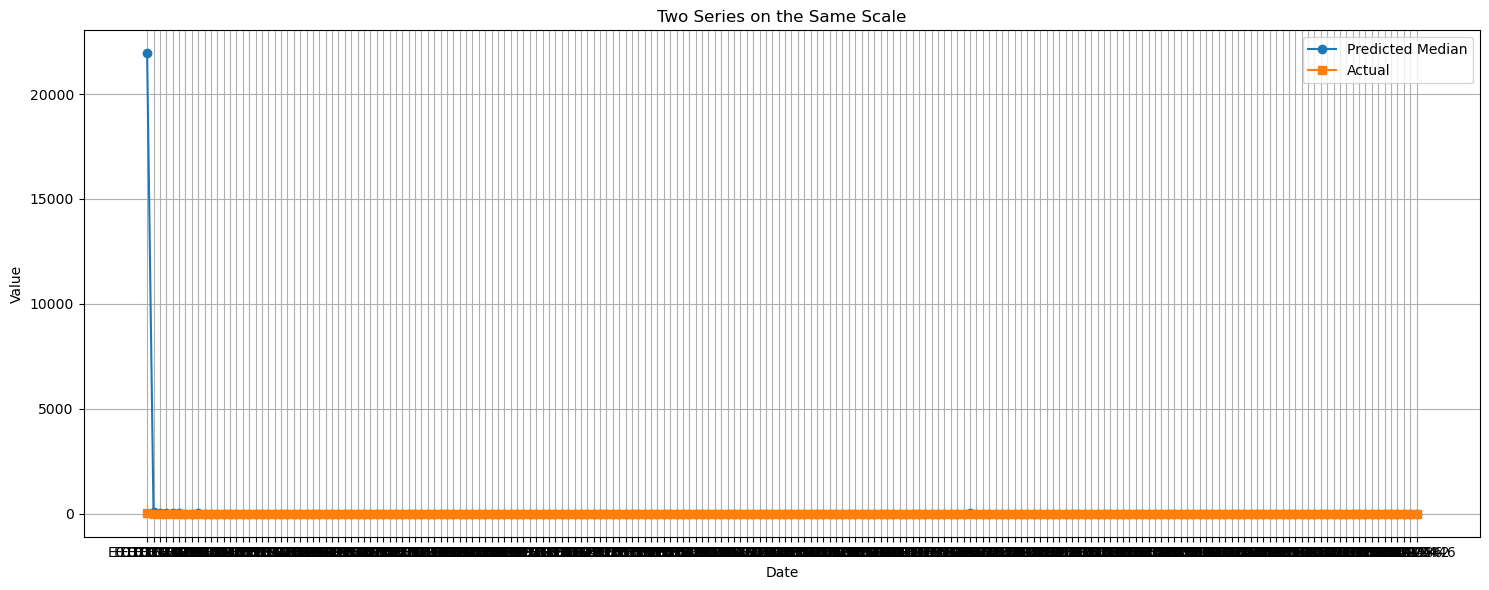

In [18]:
import matplotlib.pyplot as plt
wtf = check.nlargest(200, columns=["diff"])
plt.figure(figsize=(15, 6))
plt.plot(wtf.index, wtf["median"], marker='o', label="Predicted Median")
plt.plot(wtf.index, wtf["true"], marker='s', label="Actual")

plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Two Series on the Same Scale")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
check[["median", "true", "diff"]].describe()

,median,true,diff
count,4964.000000,4964.000000,4964.000000
mean,4.808824,0.861201,3.947623
std,311.427032,1.573978,311.199585
min,0.000000,0.000000,-21.000000
25%,0.000000,0.000000,-1.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000
max,21942.000000,23.000000,21925.000000
